# 1. Import the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 2. Load the Letter Recognition data.
## Pull data online and rename the columns.

In [2]:
raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data',header=None, sep = ',')
features = ['lettr', 'x-box', 'y-box', 'width', 'high', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']
raw_data.columns = features

# 3. Find the pairs and make them a new data set.
## 3.1 Pair 1: H and K; 

In [3]:
HK = raw_data[raw_data['lettr'].isin(['H', 'K'])]
le = LabelEncoder()
le.fit(HK['lettr'])

# Transform the target column using the LabelEncoder
HK['lettr'] = le.transform(HK['lettr'])
HK = HK.reset_index(drop=True)
HK_X_train, HK_X_test, HK_y_train, HK_y_test = train_test_split(HK.drop('lettr', axis=1), HK['lettr'], test_size=0.1, random_state=514)
# Reset index of HK_X_train
HK_X_train = HK_X_train.reset_index(drop=True)

# Reset index of HK_X_test
HK_X_test = HK_X_test.reset_index(drop=True)

# Reset index of HK_y_train
HK_y_train = HK_y_train.reset_index(drop=True)

# Reset index of HK_y_test
HK_y_test = HK_y_test.reset_index(drop=True)



/var/folders/2z/xx_s870x0kd3j9xrkh_8bg900000gn/T/ipykernel_88611/764930586.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HK['lettr'] = le.transform(HK['lettr'])


## 3.2 Pair 2: M and Y;

In [4]:
MY = raw_data[raw_data['lettr'].isin(['M', 'Y'])]
MY = MY.reset_index(drop=True)
MY_X_train, MY_X_test, MY_y_train, MY_y_test = train_test_split(MY.drop('lettr', axis=1), MY['lettr'], test_size=0.1, random_state=514)

## 3.3 Pair 3: X and T;

In [83]:
XT = raw_data[raw_data['lettr'].isin(['X','T'])]
XT = XT.reset_index(drop=True)
XT_X_train, XT_X_test, XT_y_train, XT_y_test = train_test_split(XT.drop('lettr', axis=1), XT['lettr'], test_size=0.1, random_state=514)

# 4. Model Fitting

## 4.1 K-nearest neighbors

### 4.1.1 Preparation

In [84]:
class KNearestNeighbor:

    def __init__(self, k=3):
        self.n_neighbors = k

    def train(self, X, y):
        self.X_train = X
        self.y_train = y

    def euclidean_distance(self, row1, row2):
        return np.sqrt(np.sum((row1 - row2)**2))

    def predict(self, X_test):
        y_pred = []
        
        for i in range(len(X_test)):
            distances = []
            
            for j in range(len(self.X_train)):
                dist = self.euclidean_distance(X_test.iloc[i, :], self.X_train.iloc[j, :])
                
                distances.append((j, dist))
            
            sorted_distances = sorted(distances, key=lambda x: x[1])
            k_nearest_neighbors = [self.y_train[x[0]] for x in sorted_distances[:self.n_neighbors]]
            most_common_label = max(set(k_nearest_neighbors), key=k_nearest_neighbors.count)
            y_pred.append(most_common_label)
            
        return y_pred
            
KNN = KNearestNeighbor(k=8)
KNN.train(HK_X_train.reset_index(drop=True), HK_y_train.reset_index(drop=True))
HK_y_pred = KNN.predict(HK_X_test)
acc = np.mean(HK_y_pred == HK_y_test)
print('测试集预测准确率：%f' % acc)

测试集预测准确率：0.952703


### 4.1.2 Hyper parameter Tuning
Here I decided to make k the hyper-parameter that I am going to tune.

In [86]:
import numpy as np

# Define the range of parameters to tune
k_values = [3, 5, 8, 10]

# Define the number of folds for k-fold cross-validation
k = 5

# Shuffle the data
indices = np.random.permutation(len(HK_X_train))

# Divide the data into k-folds
fold_size = len(HK_X_train) // k
folds = [(i * fold_size, (i + 1) * fold_size) for i in range(k)]
folds[-1] = (folds[-1][0], len(HK_X_train))

# Perform hyperparameter tuning for each fold
scores = []
for i in range(k):
    # Split the data into training and validation sets
    validation_indices = list(range(folds[i][0], folds[i][1]))
    training_indices = list(set(indices) - set(validation_indices))
    training_features = HK_X_train.iloc[training_indices]
    training_labels = HK_y_train.iloc[training_indices]
    validation_features = HK_X_train.iloc[validation_indices]
    validation_labels = HK_y_train.iloc[validation_indices]
    
    # Train and evaluate the model for each k value
    for k_val in k_values:
        # Create a KNearestNeighbor model
        knn = KNearestNeighbor(k=k_val)
        
        # Train the model on the training set
        knn.train(training_features.reset_index(drop=True), training_labels.reset_index(drop=True))
        
        # Evaluate the model on the validation set and record the score
        y_pred = knn.predict(validation_features)
        score = np.mean(y_pred == validation_labels)
        scores.append(score)

# Compute the average score across all folds for each k value
avg_scores = []
for i in range(len(k_values)):
    k_scores = scores[i::len(k_values)]
    avg_score = np.mean(k_scores)
    avg_scores.append(avg_score)

# Find the best k value and train the final model on the entire training set
best_k = k_values[np.argmax(avg_scores)]
final_knn = KNearestNeighbor(k=best_k)
final_knn.train(HK_X_train, HK_y_train)

# Evaluate the final model on the test set
y_pred = final_knn.predict(HK_X_test)
acc = np.mean(y_pred == HK_y_test)
print('测试集预测准确率：%f' % acc)


KeyboardInterrupt: 

## 4.2 SVM

In [155]:
class SVM:
    
    def __init__(self, learning_rate=0.01, kernel='linear', gamma=1, degree=3, C=1, bias=True, num_epochs=1000, regularization_param=0.01):
        self.lr = learning_rate
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.C = C
        self.bias = bias
        self.reg = regularization_param
        self.num_epochs = num_epochs
        
    def fit(self, X, y):
        n, m = X.shape
        y = y.values.reshape(-1, 1) * 2 - 1  # Convert labels to -1 or 1
        self.X_train = X
        
        if self.kernel == 'linear':
            K = np.dot(X, X.T)
        elif self.kernel == 'poly':
            K = (self.gamma * np.dot(X, X.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            n = X.shape[0]
            X_norms = np.sum(X.values ** 2, axis=1).reshape((n, 1))
            X_norms_squared = np.tile(X_norms, (1, n))
            distance_squared = X_norms_squared + X_norms_squared.T - 2 * np.dot(X, X.T)
            K = np.exp(-self.gamma * distance_squared)

        self.w = np.zeros((n, 1))
        if self.bias:
            self.b = 0
        else:
            self.b = None
        
        for epoch in range(self.num_epochs):
            y_pred = np.dot(K, self.w) + self.b if self.bias else np.dot(K, self.w)
            loss = np.maximum(0, 1 - y_pred * y).mean() + 0.5 * self.reg * np.sum(self.w ** 2)
            grad_w = np.dot(K.T, -y * (y_pred <= 1)) / n + self.reg * self.w

            self.w = self.w.reshape(-1, 1)
            grad_w = grad_w.reshape(-1, 1)
            self.w -= self.lr * grad_w
            
            if self.bias:
                grad_b = -np.mean(y * (y_pred <= 1))
                self.b -= self.lr * grad_b

    def predict(self, X):
        if self.kernel == 'linear':
            K = np.dot(X, self.w)
        elif self.kernel == 'poly':
            K = (self.gamma * np.dot(X, X.T) + 1) ** self.degree
        elif self.kernel == 'rbf':
            print(X.shape)
            X_arr = X.values
            K = np.exp(-self.gamma * np.sum((X_arr[:, np.newaxis, :] - self.X_train.values) ** 2, axis=2))

        if self.bias:
            return np.sign(np.dot(K, self.w) + self.b).flatten()
        else:
            return np.sign(np.dot(K, self.w)).flatten()



In [156]:
svm = SVM(kernel='rbf', gamma=0.5)
svm.fit(HK_X_train.reset_index(drop=True), HK_y_train.reset_index(drop=True))
HK_X_test=HK_X_test.reset_index(drop=True)
HK_y_pred = svm.predict(HK_X_test)

HK_y_pred = np.where(HK_y_pred == -1, 0, HK_y_pred)

acc = np.mean(HK_y_pred == (HK_y_test.reset_index(drop=True)))
print('测试集预测准确率：%f' % acc)

(148, 16)
测试集预测准确率：0.729730


(148, 16)
(148, 16)
(148, 16)
(148, 16)
(148, 16)
(148, 16)


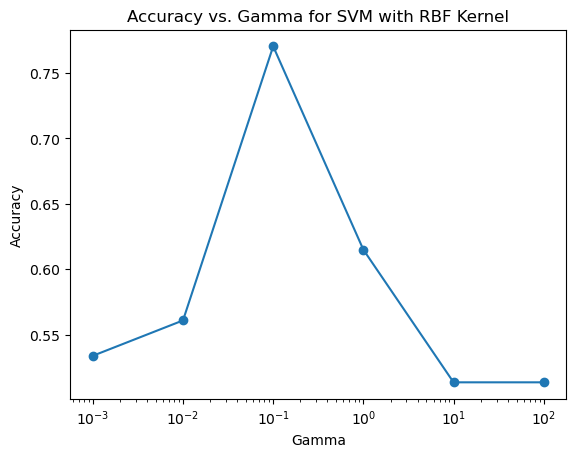

In [157]:
import matplotlib.pyplot as plt

gammas = [0.001, 0.01, 0.1, 1, 10, 100]
accs = []
for g in gammas:
    svm = SVM(kernel='rbf', gamma=g)
    svm.fit(HK_X_train.reset_index(drop=True), HK_y_train.reset_index(drop=True))
    HK_y_pred = svm.predict(HK_X_test.reset_index(drop=True))
    HK_y_pred = np.where(HK_y_pred == -1, 0, HK_y_pred)
    acc = np.mean(HK_y_pred == (HK_y_test.reset_index(drop=True)))
    accs.append(acc)

plt.plot(gammas, accs, '-o')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Gamma for SVM with RBF Kernel')
plt.show()


# 5. Dimension reductions
## 5.1 Filter Methods

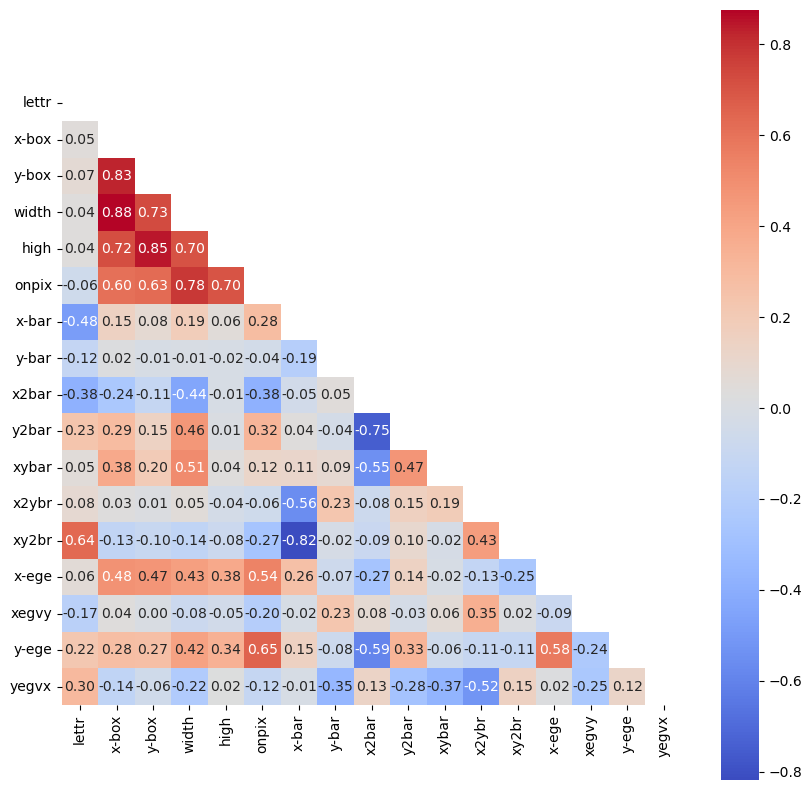

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = HK.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', square=True)
plt.show()


In [175]:
corr_df = pd.DataFrame(corr.drop('lettr', axis=1), columns=features[1:], index=features[1:])
corr_df = corr_df.unstack().reset_index()
corr_df.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_df = corr_df[corr_df['Feature 1'] != corr_df['Feature 2']]
corr_df['Abs Correlation'] = corr_df['Correlation'].abs()
corr_df = corr_df.sort_values('Abs Correlation', ascending=False)

print(corr_df)


    Feature 1 Feature 2  Correlation  Abs Correlation
32      width     x-box     0.875559         0.875559
2       x-box     width     0.875559         0.875559
19      y-box      high     0.847732         0.847732
49       high     y-box     0.847732         0.847732
16      y-box     x-box     0.826321         0.826321
..        ...       ...          ...              ...
38      width     y-bar    -0.010157         0.010157
56       high     y2bar     0.008349         0.008349
131     y2bar      high     0.008349         0.008349
29      y-box     xegvy     0.001745         0.001745
209     xegvy     y-box     0.001745         0.001745

[240 rows x 4 columns]
